In [13]:
import os
import cv2
import torch
import json
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from detectron2.checkpoint import DetectionCheckpointer
from fakeholo.data import HoloSample
from fakeholo.generator import SampleGenerator
from fakeholo.data import HoloImage
from holodino.inference import MaskDinoModel
from holodino.config import get_configuration
from holodino.trainer import Trainer
from holodino.reconstructor import Reconstructor
from holodino.filters import ScoreFilter

## Setup

1. Follow the steps in the "Model folder" section of the readme

## Figure 1

<img src="data/figure1.png" width=600/>

This figure is generated using [Draw.io](https://www.drawio.com/)

Simply enter the the `model_diagram.drawio` file into the editor at the website

For loading the model itself, follow this code:

criterion.weight_dict  {'loss_ce': 0.1, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_bbox': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 0.1, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_bbox_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 0.1, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_bbox_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 0.1, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_bbox_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 0.1, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_bbox_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 0.1, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_bbox_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 0.1, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_bbox_dn_0': 5.0, 'loss_giou_dn_0': 2.0, 'loss_ce_interm_dn_0': 0.1, 'loss_mask_interm_dn_0': 5.0, 'loss_dice_interm_dn_0': 5.0, 'loss_bbox_interm_dn_0': 5.0, 'loss_giou_interm_dn_0': 2.0, 'loss_ce_1': 0.1, 'loss_mask_1':

/opt/conda/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

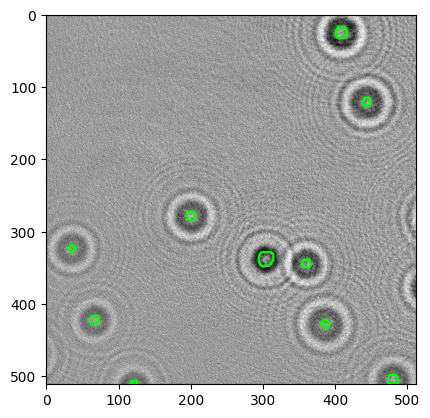

In [10]:
model = MaskDinoModel('holodino', os.path.join('models', 'holodino', 'model_final.pth'), filters=[ScoreFilter(0.5)])
image = HoloImage.from_file(os.path.join('datasets', 'waterdroplets', 'images', 'waterdroplets02.png'))
pred = model.get_prediction(image)
canvas = np.array(image)
canvas = pred.draw(canvas[...,None].repeat(3, axis=-1), contours=True, boxes=False)
plt.imshow(canvas, 'gray')

## Figure 2

<img src="data/figure2.png" width=300/>

This is a synthetic hologram generated with fakeholo.

You can use this to generate that hologram:

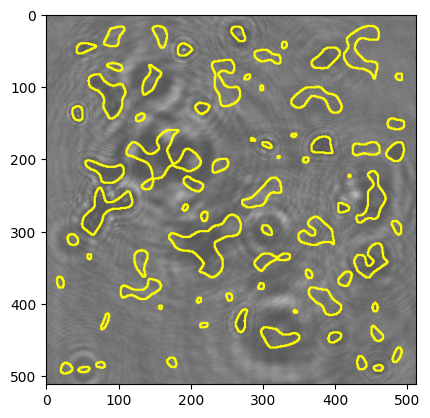

In [3]:
config = json.loads('{"contour_gen": {"kernel_size": 8, "threshold": 0.94, "min_area": 5, "max_count": 300, "pinch_threshold": 0.0, "circularity_threshold": 0.0, "solidity_threshold": 0.0, "type": "Blob"}, "medium": {"ior": {"real": {"vmin": 0.3, "vmax": 1.3, "dist": "Uniform"}, "imaginary": {"vmin": 0.0, "vmax": 0.0, "dist": "Uniform"}}, "intensity": {"vmin": 0.2, "vmax": 1.0, "dist": "Uniform"}}, "laser": {"wavelength": {"vmin": 0.238, "vmax": 0.938, "dist": "Uniform"}}, "property_gen": {"depth": {"vmin": 1000.0, "vmax": 1000000.0, "dist": "Exponential"}, "far_field_thresh": 1000000.0, "distribution": "exponential", "ior": {"real": {"vmin": 1.0, "vmax": 1.8, "dist": "Uniform"}, "imaginary": {"vmin": 0.0, "vmax": 1.0, "dist": "Uniform"}}, "random_max": false}, "synthesis": {"output_size": [512, 512], "resolution": 4.0, "oversample": 1, "gaussian_sigma": 99, "gaussian": false, "padding": true}, "seed": 8, "torch": true}')
sample = SampleGenerator.from_dict(config).generate()
img = sample.image.as_arr[..., None].repeat(3, axis=-1)
for contour in sample.bounding_boxes:
    contour.draw_contour(img, (255, 255, 0))
plt.imshow(img)

## Figure 3

<img src="data/lowconfar.png" width=150/>
<img src="data/highconfar.png" width=150/>
<img src="data/ad.png" width=150/>
<img src="data/wd.png" width=150/>

These are simply samples from our dataset, you can run inference on them if you'd like, but otherwise these are just to demonstrate what our datasets look like.

We did, through latex, crop the Dental Particles image as well as added a scale bar to both the experimental datasets. But the images themselves are otherwise unaltered.

## Figure 4

<img src="data/figure4_a.png" width=100/>
<img src="data/figure4_b.png" width=100/>

These are obtained by focusing in via holographic reconstruction. We've attached the original hologram so you can see how we do this here:

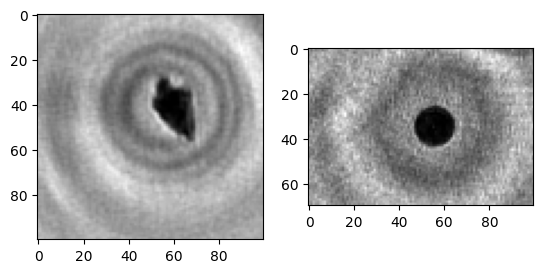

In [4]:
fig, axes = plt.subplots(1, 2)
ad = Image.open('data/ad_focused.png')
wd = Image.open('data/wd_focused.tif')
recon = Reconstructor(
    resolution=3.4,
    wavelength=0.405
)
r = recon.intensity(
    np.array(ad),
    [412*41]
)
axes[0].imshow(r[0, 700:, 700:800], cmap='gray')
recon = Reconstructor(
    resolution=18.2,
    wavelength=0.632
)
r = recon.intensity(
    np.array(wd),
    [4300*67]
)
axes[1].imshow(r[0,250:320,350:450], cmap='gray')

## Figure 5

<img src="data/figure5.png" width=300/>

Same as before, this figure is generated using [Draw.io](https://www.drawio.com/)

Simply enter the the `model_diagram.drawio` file into the editor at the website

## Figure 6

<img src="data/figure6a.png" width=150/>
<img src="data/figure6b.png" width=150/>
<img src="data/figure6c.png" width=150/>
<img src="data/figure6d.png" width=150/>

These are the results of our model and a bounding box model. The bounding box model weights are not public, but we can still share our own results here:

criterion.weight_dict  {'loss_ce': 0.1, 'loss_mask': 5.0, 'loss_dice': 5.0, 'loss_bbox': 5.0, 'loss_giou': 2.0, 'loss_ce_interm': 0.1, 'loss_mask_interm': 5.0, 'loss_dice_interm': 5.0, 'loss_bbox_interm': 5.0, 'loss_giou_interm': 2.0, 'loss_ce_dn': 0.1, 'loss_mask_dn': 5.0, 'loss_dice_dn': 5.0, 'loss_bbox_dn': 5.0, 'loss_giou_dn': 2.0, 'loss_ce_interm_dn': 0.1, 'loss_mask_interm_dn': 5.0, 'loss_dice_interm_dn': 5.0, 'loss_bbox_interm_dn': 5.0, 'loss_giou_interm_dn': 2.0, 'loss_ce_0': 0.1, 'loss_mask_0': 5.0, 'loss_dice_0': 5.0, 'loss_bbox_0': 5.0, 'loss_giou_0': 2.0, 'loss_ce_interm_0': 0.1, 'loss_mask_interm_0': 5.0, 'loss_dice_interm_0': 5.0, 'loss_bbox_interm_0': 5.0, 'loss_giou_interm_0': 2.0, 'loss_ce_dn_0': 0.1, 'loss_mask_dn_0': 5.0, 'loss_dice_dn_0': 5.0, 'loss_bbox_dn_0': 5.0, 'loss_giou_dn_0': 2.0, 'loss_ce_interm_dn_0': 0.1, 'loss_mask_interm_dn_0': 5.0, 'loss_dice_interm_dn_0': 5.0, 'loss_bbox_interm_dn_0': 5.0, 'loss_giou_interm_dn_0': 2.0, 'loss_ce_1': 0.1, 'loss_mask_1':

/opt/conda/lib/python3.11/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

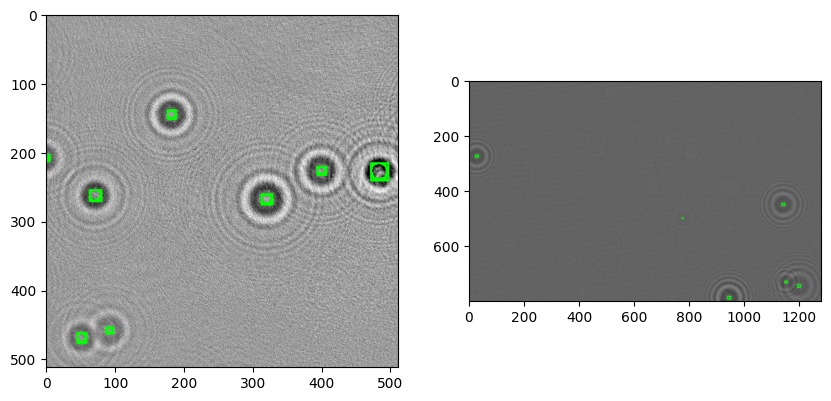

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
model = MaskDinoModel('holodino', os.path.join('models', 'holodino', 'model_final.pth'), filters=[ScoreFilter(0.5)])
wd = HoloImage.from_file(os.path.join('data', 'wd_inference.tif'))
ad = HoloImage.from_file(os.path.join('data', 'ad_inference.png'))
def draw(image):
    pred = model.get_prediction(image)
    canvas = np.array(image)
    canvas = pred.draw(canvas[...,None].repeat(3, axis=-1), contours=True, boxes=True)
    return canvas
wd_hd = draw(wd)
ad_hd = draw(ad)
axes[0].imshow(wd_hd)
axes[1].imshow(ad_hd)

## Figure 7

<img src="data/figure7_a.png" width=300/>
<img src="data/figure7_b.png" width=300/>

This one is a bit more complex, you just need to run the model over all samples in our data. This is pretty routine, albeit time consuming. For brevity, we've attached an output_data.csv which contains the relevant ROC and F1 scores for our model.

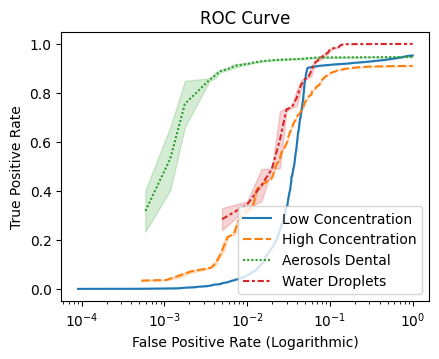

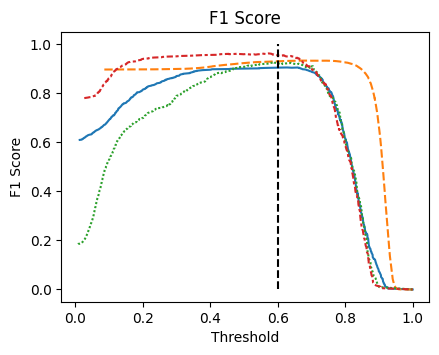

In [ ]:
data = pd.read_csv(os.path.join('data', 'output_data.csv'))

plt.figure(figsize=(4.75, 3.5))
order = ['Low Concentration', 'High Concentration', 'Aerosols Dental', 'Water Droplets']
sns.lineplot(data=data[data['metric'] == 'roc'], x='threshold', y='value', hue='dataset', style='dataset', hue_order=order, style_order=order)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate (Logarithmic)')
plt.title('ROC Curve')
plt.xscale('log')
ax = plt.gca()
ax.title.set_fontsize(12)
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)

plt.legend(loc='lower right', prop={'size': 10})
plt.show()

plt.figure(figsize=(4.75, 3.5))
sns.lineplot(data=data[data['metric'] == 'f1'], x='threshold', y='value', hue='dataset', style='dataset', hue_order=order, style_order=order)
plt.plot([0.6, 0.6], [0, 1], 'k--')
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.title('F1 Score')
ax = plt.gca()
ax.title.set_fontsize(12)
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(10)
plt.legend().remove()
plt.savefig('figure5_b.png', bbox_inches='tight', dpi=600)